In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path('./data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
data['date']=pd.to_datetime(data['Time'],unit='s')

In [4]:
data

,UserId,ItemId,Rating,Time,date
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


# Step 1. 데이터의 전처리
---
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.<br>

Rating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.<br>

Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.<br>

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

### Session Length

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   UserId  1000209 non-null  int32         
 1   ItemId  1000209 non-null  int32         
 2   Rating  1000209 non-null  int32         
 3   Time    1000209 non-null  int64         
 4   date    1000209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(3), int64(1)
memory usage: 34.3 MB


In [6]:
data['UserId'].nunique(),data['ItemId'].nunique()

(6040, 3706)

In [7]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [8]:
session_length.min(),session_length.max(),session_length.median(), session_length.mean()

(20, 2314, 96.0, 165.5975165562914)

In [9]:
session_length.quantile(0.999)

1343.181000000005

In [10]:
long_session = session_length[session_length==2314].index[0]
long_session

4169

In [11]:
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time,date
696969,4169,1268,5,965333392,2000-08-03 20:09:52
697168,4169,2617,4,965333392,2000-08-03 20:09:52
697185,4169,2628,4,965333392,2000-08-03 20:09:52
697219,4169,2653,4,965333392,2000-08-03 20:09:52
697275,4169,423,3,965333392,2000-08-03 20:09:52
...,...,...,...,...,...
697882,4169,3754,2,1024174347,2002-06-15 20:52:27
695702,4169,1413,3,1024175031,2002-06-15 21:03:51
697358,4169,494,4,1024175760,2002-06-15 21:16:00
695945,4169,1804,2,1024175783,2002-06-15 21:16:23


In [12]:
df_session_length = pd.DataFrame(session_length)

In [13]:
df_session_length

,0
UserId,
1,53
2,129
3,51
4,21
5,198
...,...
6036,888
6037,202
6038,20


In [14]:
# userid별 몇개의 데이터가 존재하는가 -> 존재하는 데이터 개수가 같은 경우는 모두 더해 보자
# 세션 개수로 정렬해서 표시한 것임
length_count = df_session_length.value_counts().sort_index() 
length_count

20      86
21      91
22      77
23      81
24      81
        ..
1521     1
1595     1
1743     1
1850     1
2314     1
Length: 743, dtype: int64

In [15]:
df_length_count = pd.DataFrame(length_count,columns=['count_sum'])
df_length_count.rename_axis(index='count',inplace=True)
df_length_count

,count_sum
count,
20,86
21,91
22,77
23,81
24,81
...,...
1521,1
1595,1
1743,1


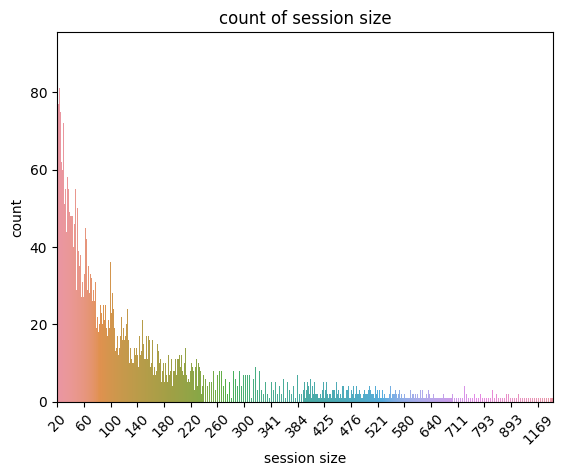

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

ax = sns.barplot(x='count',y='count_sum',data=df_length_count.reset_index())
ax.set_title('count of session size')
ax.set_xlabel('session size')
ax.set_ylabel('count')
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=40.0))
for item in ax.get_xticklabels():
    item.set_rotation(45)
plt.show()

In [17]:
data.groupby('UserId').size().mean() # 평균적으로 26개 세션이 존재함

165.5975165562914

In [18]:
data.groupby('ItemId').size().mean() # 평균적으로 3.7개 종류의 item을 보았음

269.88909875876953

## Session Time

In [19]:
oldest, latest = data['date'].min(), data['date'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [20]:
month_ago = latest - dt.timedelta(180)     # 영화 추천이므로 최종 날짜로부터 180일 이전 날짜를 구한다.  
data = data[data['date'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,UserId,ItemId,Rating,Time,date
5200,36,2269,5,1040544350,2002-12-22 08:05:50
5256,36,1701,4,1040544350,2002-12-22 08:05:50
5184,36,2694,3,1040544494,2002-12-22 08:08:14
5364,36,3786,4,1040544521,2002-12-22 08:08:41
5262,36,2369,4,1040544564,2002-12-22 08:09:24
...,...,...,...,...,...
984733,5950,1262,4,1046369858,2003-02-27 18:17:38
986778,5956,469,3,1033358097,2002-09-30 03:54:57
992702,5996,168,3,1031058746,2002-09-03 13:12:26
992459,5996,339,4,1033997079,2002-10-07 13:24:39


## Data Cleansing

In [21]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [22]:
data = cleanse_recursive(data, shortest=2, least_click=2)
data

,UserId,ItemId,Rating,Time,date
5200,36,2269,5,1040544350,2002-12-22 08:05:50
5256,36,1701,4,1040544350,2002-12-22 08:05:50
5184,36,2694,3,1040544494,2002-12-22 08:08:14
5364,36,3786,4,1040544521,2002-12-22 08:08:41
5262,36,2369,4,1040544564,2002-12-22 08:09:24
...,...,...,...,...,...
984660,5950,3555,2,1046369737,2003-02-27 18:15:37
984733,5950,1262,4,1046369858,2003-02-27 18:17:38
992702,5996,168,3,1031058746,2002-09-03 13:12:26
992459,5996,339,4,1033997079,2002-10-07 13:24:39


In [23]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['date'].max()
    session_last_time = data.groupby('UserId')['date'].max().sort_values()
    session_in_train = data[data['date'] < final_time - dt.timedelta(n_days)]
    session_in_test = data[data['date'] >= final_time - dt.timedelta(n_days)]

    #before_date = data[data['UserId'].isin(session_in_train)]
    #after_date = data[data['UserId'].isin(session_in_test)]
    #after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return session_in_train, session_in_test

In [24]:
data = data.sort_values(by=['date'])

In [25]:
tr, test = split_by_date(data, n_days=2)
tr, val = split_by_date(tr, n_days=2)

In [26]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["date"].min()}\n'
          f'\t Last Time : {data["date"].max()}\n')

In [27]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 7787
	 Sessions: 300
	 Items: 1582
	 First Time : 2002-09-01 19:43:16
	 Last Time : 2003-02-24 06:02:24

* valid Set Stats Info
	 Events: 196
	 Sessions: 7
	 Items: 192
	 First Time : 2003-02-24 17:02:07
	 Last Time : 2003-02-26 16:18:03

* test Set Stats Info
	 Events: 57
	 Sessions: 10
	 Items: 55
	 First Time : 2003-02-27 04:30:55
	 Last Time : 2003-02-28 17:49:50



In [28]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [29]:
save_path = data_path / 'processed_2'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# Step 2. 미니 배치의 구성
---
실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [30]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [31]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head()

,UserId,ItemId,Rating,Time,date,item_idx
52182,343,258,4,1030909396,2002-09-01 19:43:16,0
52020,343,2080,5,1030909495,2002-09-01 19:44:55,1
52187,343,3479,5,1030909508,2002-09-01 19:45:08,2
52216,343,39,4,1030910322,2002-09-01 19:58:42,3
328061,1941,627,4,1030916082,2002-09-01 21:34:42,4


In [32]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [33]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,date,item_idx
52182,343,258,4,1030909396,2002-09-01 19:43:16,0
52020,343,2080,5,1030909495,2002-09-01 19:44:55,1
52187,343,3479,5,1030909508,2002-09-01 19:45:08,2
52216,343,39,4,1030910322,2002-09-01 19:58:42,3
328061,1941,627,4,1030916082,2002-09-01 21:34:42,4
328062,1941,628,4,1030916395,2002-09-01 21:39:55,5
327706,1941,2445,3,1030917230,2002-09-01 21:53:50,6
223132,1352,1218,3,1030917255,2002-09-01 21:54:15,7
328109,1941,2126,2,1030917565,2002-09-01 21:59:25,8
327778,1941,204,2,1030917889,2002-09-01 22:04:49,9


In [34]:
iter_ex = iter(tr_data_loader)

In [35]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  13 116  26]
Label Item Idx are :       [  1  14 117 118]
Previous Masked Input Idx are []


# Step 3. 모델 구성
---
이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [37]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [43]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=4, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)

In [44]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(4, 1, 1582)]            0         
_________________________________________________________________
GRU (GRU)                    [(4, 50), (4, 50)]        245100    
_________________________________________________________________
dropout_1 (Dropout)          (4, 50)                   0         
_________________________________________________________________
dense_1 (Dense)              (4, 1582)                 80682     
Total params: 325,782
Trainable params: 325,782
Non-trainable params: 0
_________________________________________________________________


# Step 4. 모델 학습
---
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [40]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [41]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [45]:
train_model(model, args)

Train:  97%|█████████▋| 1807/1871 [00:20<00:00, 90.05it/s, accuracy=0, train_loss=7.3]    


total_step= 189


Evaluation:  11%|█         | 5/47 [00:00<00:03, 11.75it/s]


	 - Recall@20 epoch 1: 0.100000
	 - MRR@20    epoch 1: 0.011250



Train:  97%|█████████▋| 1807/1871 [00:19<00:00, 93.03it/s, accuracy=0, train_loss=7.09]   


total_step= 189


Evaluation:  11%|█         | 5/47 [00:00<00:02, 20.43it/s]


	 - Recall@20 epoch 2: 0.050000
	 - MRR@20    epoch 2: 0.002500



Train:  97%|█████████▋| 1807/1871 [00:19<00:00, 92.80it/s, accuracy=0, train_loss=6.87]   


total_step= 189


Evaluation:  11%|█         | 5/47 [00:00<00:02, 20.27it/s]


	 - Recall@20 epoch 3: 0.050000
	 - MRR@20    epoch 3: 0.005000



Train:  97%|█████████▋| 1807/1871 [00:19<00:00, 93.81it/s, accuracy=0, train_loss=6.8]    


total_step= 189


Evaluation:  11%|█         | 5/47 [00:00<00:02, 20.71it/s]


	 - Recall@20 epoch 4: 0.100000
	 - MRR@20    epoch 4: 0.015000



Train:  97%|█████████▋| 1807/1871 [00:19<00:00, 94.41it/s, accuracy=0, train_loss=6.43]   


total_step= 189


Evaluation:  11%|█         | 5/47 [00:00<00:02, 20.19it/s]


	 - Recall@20 epoch 5: 0.100000
	 - MRR@20    epoch 5: 0.020833



Train:  97%|█████████▋| 1807/1871 [00:19<00:00, 92.52it/s, accuracy=0, train_loss=6.02]   


total_step= 189


Evaluation:  11%|█         | 5/47 [00:00<00:01, 21.68it/s]


	 - Recall@20 epoch 6: 0.050000
	 - MRR@20    epoch 6: 0.012500



Train:  97%|█████████▋| 1807/1871 [00:19<00:00, 91.54it/s, accuracy=0, train_loss=5.68]   


total_step= 189


Evaluation:  11%|█         | 5/47 [00:00<00:02, 19.65it/s]


	 - Recall@20 epoch 7: 0.050000
	 - MRR@20    epoch 7: 0.005000



Train:  97%|█████████▋| 1807/1871 [00:19<00:00, 91.03it/s, accuracy=0, train_loss=5.3]    


total_step= 189


Evaluation:  11%|█         | 5/47 [00:00<00:02, 20.48it/s]


	 - Recall@20 epoch 8: 0.050000
	 - MRR@20    epoch 8: 0.003571



Train:  97%|█████████▋| 1807/1871 [00:19<00:00, 93.42it/s, accuracy=0.25, train_loss=4.69]


total_step= 189


Evaluation:  11%|█         | 5/47 [00:00<00:01, 21.01it/s]


	 - Recall@20 epoch 9: 0.050000
	 - MRR@20    epoch 9: 0.004545



Train:  97%|█████████▋| 1807/1871 [00:19<00:00, 92.80it/s, accuracy=0.25, train_loss=4.5] 


total_step= 189


Evaluation:  11%|█         | 5/47 [00:00<00:02, 20.64it/s]


	 - Recall@20 epoch 10: 0.050000
	 - MRR@20    epoch 10: 0.003846



Train:  97%|█████████▋| 1807/1871 [00:19<00:00, 92.43it/s, accuracy=0.5, train_loss=4.03] 


total_step= 189


Evaluation:  11%|█         | 5/47 [00:00<00:02, 20.83it/s]


	 - Recall@20 epoch 11: 0.050000
	 - MRR@20    epoch 11: 0.005000



Train:  97%|█████████▋| 1807/1871 [00:19<00:00, 92.06it/s, accuracy=0.5, train_loss=3.59] 


total_step= 189


Evaluation:  11%|█         | 5/47 [00:00<00:02, 20.57it/s]


	 - Recall@20 epoch 12: 0.100000
	 - MRR@20    epoch 12: 0.008056



Train:  97%|█████████▋| 1807/1871 [00:19<00:00, 93.85it/s, accuracy=0.5, train_loss=2.95] 


total_step= 189


Evaluation:  11%|█         | 5/47 [00:00<00:01, 21.84it/s]


	 - Recall@20 epoch 13: 0.050000
	 - MRR@20    epoch 13: 0.005556



Train:  97%|█████████▋| 1807/1871 [00:19<00:00, 93.06it/s, accuracy=0.5, train_loss=2.99] 


total_step= 189


Evaluation:  11%|█         | 5/47 [00:00<00:02, 20.83it/s]


	 - Recall@20 epoch 14: 0.050000
	 - MRR@20    epoch 14: 0.004545



Train:  97%|█████████▋| 1807/1871 [00:19<00:00, 93.60it/s, accuracy=0.5, train_loss=2.12] 


total_step= 189


Evaluation:  11%|█         | 5/47 [00:00<00:02, 20.64it/s]


	 - Recall@20 epoch 15: 0.100000
	 - MRR@20    epoch 15: 0.007177



Train:  97%|█████████▋| 1807/1871 [00:19<00:00, 93.81it/s, accuracy=0.75, train_loss=1.99]


total_step= 189


Evaluation:  11%|█         | 5/47 [00:00<00:02, 20.32it/s]


	 - Recall@20 epoch 16: 0.100000
	 - MRR@20    epoch 16: 0.007323



Train:  97%|█████████▋| 1807/1871 [00:19<00:00, 94.20it/s, accuracy=0.75, train_loss=1.84] 


total_step= 189


Evaluation:  11%|█         | 5/47 [00:00<00:03, 11.13it/s]


	 - Recall@20 epoch 17: 0.100000
	 - MRR@20    epoch 17: 0.007108



Train:  97%|█████████▋| 1807/1871 [00:19<00:00, 93.82it/s, accuracy=0.5, train_loss=1.66]  


total_step= 189


Evaluation:  11%|█         | 5/47 [00:00<00:02, 20.90it/s]


	 - Recall@20 epoch 18: 0.100000
	 - MRR@20    epoch 18: 0.006944



Train:  97%|█████████▋| 1807/1871 [00:19<00:00, 94.08it/s, accuracy=0.75, train_loss=1.31] 


total_step= 189


Evaluation:  11%|█         | 5/47 [00:00<00:02, 20.64it/s]


	 - Recall@20 epoch 19: 0.100000
	 - MRR@20    epoch 19: 0.008333



Train:  97%|█████████▋| 1807/1871 [00:19<00:00, 93.48it/s, accuracy=0.75, train_loss=1.01] 


total_step= 189


Evaluation:  11%|█         | 5/47 [00:00<00:02, 20.74it/s]

	 - Recall@20 epoch 20: 0.100000
	 - MRR@20    epoch 20: 0.007738



# Step 5. 모델 테스트
---
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [48]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

total_step= 47


Evaluation:  18%|█▊        | 2/11 [00:00<00:00, 19.98it/s]

	 - Recall@20: 0.000000
	 - MRR@20: 0.000000

